1. **Pristup tekstu sa Wikipedije putem MapReduce programa (6 bodova)**  
Napisati program koji kroz map-reduce paradigmu (upotrebom funkcije *map* iz Python standardne biblioteke i funkcije *reduce* iz paketa *functools*):
  - Za zadatu listu ključnih reči vrši pretragu Wiki stranica i dohvata zadati broj rezultata (naslova stranica)
    Za pristup wiki stranicama se može koristiti python biblioteku [*wikipedia*](https://pypi.org/project/wikipedia/):
```python
import wikipedia
wikipedia.set_lang("sr")
```
```python
def get_pages(query, results=50):
  '''Dohvata naslove zahtevanog broja stranica koje se pojavaljuju kao 
      rezultati pretrage za zadatu kljucnu rec'''
      pages = wikipedia.search(query, results=results)
      return pages
```
  - Paralelizovati rešenje iz prethodne tačke upotrebom funkcija `Pool.map` iz paketa `multiprocessing`
  - Wikipedia API ponekad vrati nevalidne naslove stranica, pa je rezultate neophodno sanitizovati. Napisati map/reduce rešenje koje sanitizuje rezultate iz prethodne tačke. Sanitizacija se može izvesti pokušajem da dohvatanja stranice na osnovu nasova (`wikipedia.page(title)`) i hvatanjem izuzetaka.
  - Napisati map/reduce rešenje koje dohvata sažetke stranica (`page.summary`) iz sanitizovane liste formirane u prethodnoj tački.
  - Wikipedia API ponekad meša stranice na ćiriličnom i latiničnom pismu. Unifikovati tekstive dobijene u prethodnoj tački prevođenjem reči na isto pismo (ćirilično ili latinično)
  ```python
import transliterate
transliterate.translit(word, 'sr')
```
 - Odabrati nekoliko ključnih reči po slobodnom izboru i pokazati da program radi dohvatanjem po dva rezultata za svaku kljunu reč.

2. **Brojanje reci u tesktu i bag-of-words reprezentacija putem MapReduce programa (8 bodova)**  
U ovom zadatku ćemo stranice predstaviti kao *bag-of-words* vektore. *Bag-of-words* reprezentacija se dobija tako što za *sve** reči koje se pojavljuju u svim tekstovima izbrojimo koliko puta se pojavljuju u svakom tekstu. Tekst potom predstvaljamo kao vektor ovih brojeva.   
Na primer, posmatrajmo dva teksta:
``` 
Pera voli da gleda filmove. Mika takođe voli filmove.
``` 
```
Mika voli da gleda i fudbalske utakmice.
```
Reči koje se pojavljuju su:
```
Pera, voli, da, gleda, filmove, Mika, takođe, i, fudbalske, utakmice
``` 
  *Bag-of-words* reprezentacija tekstova je:
```
1, 2, 1, 1, 2, 1, 1, 0, 0, 0
```
odnosno:
```
0, 1, 1, 1, 0, 1, 0, 1, 1, 1
```
U praksi se reči koje se previše često ili previše retko pojavljuju uglavnom odbacuju. 
  - Napisati map/reduce program koji datu listu tesktiva pretvara u *Bag-of-words* reprezentaciju. Pre brojanja reči potrebno je sve reči prevesti u mala ili velika slova (po vašem izboru), te izbaciti interpunkcijske znake i specijalne karaktere (u najmanju ruku sledeći skup `\n, \t, =, -, (, ), _`). Odbaciti reči koje se pojavljuju veoma često u većini tekstovima (nalaze se u 10% najčešćih reči u bar 90% tekstova), ili se pojavljuju u manje od 1% tekstova. Ovu obradu izvesti kroz posebne map/reduce korake.
  - Ručno uneti nekoliko tekstova po slobodnom izboru i pokazati da program radi.

3. **K-means klastersanje putem MapReduce programa (5 bodova)**   
Napisati map/reduce program koji vrši k-means klasterisanje liste vektora.
Nasumično generisati podatke iz nekoliko normalnih raspodela u dve dimenzije i pokazati da algoritam radi (videti vežbe za primer). 

4. **Primena rešenja  (6 bodova)**  
Povezati kod iz zadataka 1-3 kojim se Wiki na srpskom jeziku pretražuje za sledeći skup ključnih reči `['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']`, za svaku dohvata po 50 rezultata, stranice prevode u *bag-of-words* reprezentaciju, i vrši njihovo klasterisanje. 
U kojom meri klasteri odgovaraju temama prema kojima su stranice dohvatane?

In [ ]:
!pip install wikipedia
!pip install transliterate

In [ ]:
import wikipedia, transliterate, multiprocessing, operator, math, random
import matplotlib.pyplot as plt, numpy as np 

from functools import reduce, partial
from itertools import groupby

from sklearn.preprocessing import StandardScaler        # Needed for PCA.
from sklearn.decomposition import PCA

In [ ]:
wikipedia.set_lang("sr")

keywords = [ 'Beograd', 'Prvi svetski rat' ]

In [ ]:
# Dohvata naslove zahtevanog broja stranica koje se pojavaljuju kao rezultati pretrage za zadatu kljucnu rec.
def get_pages( query, results = 50 ):

    return wikipedia.search( query, results = results )


1. a)   Za zadatu listu ključnih reči vrši pretragu Wiki stranica i dohvata zadati broj rezultata ( naslova stranica ).

In [ ]:
pages = []
for word in keywords:
    pages.extend( get_pages( word ) )

print( pages, "\n" )

1. b)   Paralelizovati rešenje iz prethodne tačke upotrebom funkcija Pool.map iz paketa multiprocessing.


In [ ]:
pool = multiprocessing.Pool( multiprocessing.cpu_count() )

pages = None
pages = pool.map( get_pages, keywords )
pool.terminate()

print( pages )


1. c)   Wikipedia API ponekad vrati nevalidne naslove stranica, pa je rezultate neophodno sanitizovati. Napisati map/reduce rešenje koje sanitizuje rezultate iz prethodne tačke. Sanitizacija se može izvesti pokušajem da dohvatanja stranice na osnovu nasova (wikipedia.page(title)) i hvatanjem izuzetaka.

In [ ]:
def sanitize( acc, title ):
    
    try:
        page = wikipedia.page( title )
        acc.append( title )
    except Exception as e:
        print( f'sanitize( \'{ title }\' ): Page not valid.' )

    return acc

pages = reduce( lambda x, y: x + y, pages, [] ) # Converting from 2D to 1D.
pages = reduce( sanitize, pages, [] )           # Sanitizing pages.

print( pages )

1. d)   Napisati map/reduce rešenje koje dohvata sažetke stranica (page.summary) iz sanitizovane liste formirane u prethodnoj tački.

In [ ]:
def summarize( acc, title ):
    
    acc.append( wikipedia.summary( title ) )
    
    return acc

summary_pages = reduce( summarize, pages, [] )
print( summary_pages )


1. e)   Wikipedia API ponekad meša stranice na ćiriličnom i latiničnom pismu. Unifikovati tekstive dobijene u prethodnoj tački prevođenjem reči na isto pismo (ćirilično ili latinično).


In [ ]:
def cirilize( acc, text ):
    
    acc.append( transliterate.translit( text, 'sr' ) )
    
    return acc

cirilized_summary = reduce( cirilize, summary_pages, [] )
print( cirilized_summary )

2.      Brojanje reci u tesktu i bag-of-words reprezentacija putem MapReduce programa (8 bodova)

        U ovom zadatku ćemo stranice predstaviti kao bag-of-words vektore. Bag-of-words reprezentacija se dobija tako što za sve* reči koje se pojavljuju
        u svim tekstovima izbrojimo koliko puta se pojavljuju u svakom tekstu. Tekst potom predstvaljamo kao vektor ovih brojeva.
        Na primer, posmatrajmo dva teksta:

        Pera voli da gleda filmove. Mika takođe voli filmove.
        Mika voli da gleda i fudbalske utakmice.

        Reči koje se pojavljuju su:
            Pera, voli, da, gleda, filmove, Mika, takođe, i, fudbalske, utakmice

        Bag-of-words reprezentacija tekstova je:
            1, 2, 1, 1, 2, 1, 1, 0, 0, 0

        odnosno:
            0, 1, 1, 1, 0, 1, 0, 1, 1, 1


U praksi se reči koje se previše često ili previše retko pojavljuju uglavnom odbacuju.

Napisati map/reduce program koji datu listu tekstova pretvara u Bag-of-words reprezentaciju. Pre brojanja reči potrebno je sve reči prevesti u mala ili velika slova (po vašem izboru), te izbaciti interpunkcijske znake i specijalne karaktere ( u najmanju ruku sledeći skup \n, \t, =, -, (, ), _ ). 

Ručno uneti nekoliko tekstova po slobodnom izboru i pokazati da program radi.


In [ ]:
testing = [ 'This movie movie is very scary and long', 'This movie is not scary and is slow', 'This movie is spooky and good' ]

# Number of Documents
N = len( testing )

# Converts string characters to lower case.
def to_lower( acc, text ):
    
    acc.append( text.lower() )
    
    return acc


#  Removes \n, \t, =, -, (, ), _
def remove_gibberish( acc, text ):
    filtered = ""
    for char in text:
        if char.isalpha() or char == ' ':
            filtered += char
        else:
            filtered += ' '
        
    acc.append( filtered )

    return acc


lower_text = reduce( to_lower, testing, [] )
print( 'Lower text:     ', lower_text )

filtered_text = reduce( remove_gibberish, lower_text, [] )
print( 'Filtered text:  ', filtered_text, '\n' )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Map function which makes key value pairs in touple: (index = text_index, key = word, value = 1).
def make_size_keyvalue( word, text_index ):
    return ( text_index, ( word, 1 ) )

def make_keyvalue( word,  ):
    return ( word, 1 )

# Reduce function that removes duplicates.
def remove_duplicates( acc, word ):
    
    if word not in acc:
        acc.append( word )
    
    return acc


index_word_size = []
for i in range( len( filtered_text ) ):

    words = filtered_text[i].split()

    partial_make_size_keyvalue = partial( make_size_keyvalue, text_index = i )
    index_word_size.extend( list( map( partial_make_size_keyvalue, words ) ) )

print( 'WORDS:      ', index_word_size )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# [3] Function that transforms group/array of groups to dictionary/array of dictionaries. [ ('X', 1), ('Y', 1), ('Y', 1) ]    --->    { 'X' : [1], 'Y' : [1, 1] }
def groups_to_dict( group ):
    return { key: [ x[1] for x in value ] for key, value in group }

my_group = groupby( index_word_size, key = lambda x: x[0] )
my_dictionary = groups_to_dict( my_group )
print( 'DICTIONARY: ', my_dictionary )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# [3] - Occurance.
def my_reduce_occurances( acc, x, text_index ):

    ( key, value ) = x

    if ( key, text_index ) in acc:
        acc[ key, text_index ].append( value )
    else:
        acc[ key, text_index ] = [ value ]

    return acc


# [2] - Occurance.
def map_occurance( key, values ):
    
    acc = {}
    sorted_values = sorted( values )
    
    partial_my_reduce_occurances = partial( my_reduce_occurances, text_index = key )

    return reduce( partial_my_reduce_occurances, sorted_values, acc ) 


# [1] - Occurance.
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
my_occurance = list( pool.starmap( map_occurance, my_dictionary.items() ) )
pool.terminate()
print( '\n' )
print('OCCURANCE: ', my_occurance )


def reduce_merge_occurance( acc, x ):
    acc.update( x )
    return acc

my_merge_occurace = reduce( reduce_merge_occurance, my_occurance, {} )
print( 'OCCURACE (MERGE): ', my_merge_occurace)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# [2] - Number of words per text.
def reduce_get_number_of_words( acc, x ):

    acc[ x[0][1] ] = acc[ x[0][1] ] + len( x[1] )
    
    return acc

# [1] - Number of words per text.
acc = N * [ 0 ]
number_of_words_per_text = reduce( reduce_get_number_of_words, my_merge_occurace.items(), acc ) 

print( '\n' )
print( 'WORDS PER TEXT: ', number_of_words_per_text )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# [2] - All unique words.
def reduce_extract_words( acc, x ):
    acc.extend( x[1] )
    return acc

# [1] - All unique words.
all_words = reduce( reduce_extract_words, my_dictionary.items(), [] )

# [3] - All unique words.
all_words_set = sorted( set( all_words ) )

# [4] - All unique words.
all_unique_words = reduce( operator.or_, [ all_words_set ] )

print( 'ALL UNIQUE WORDS: ', all_unique_words )
print( '\n' )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# [4] Bag of words.
def reduce_bag_of_words( acc, x, text_index ):
    
    ( key, value ) = x

    acc[ key, text_index ].append( value )

    return acc

# [3] Bag of words.
def reduce_make_bag_of_words( acc, x, text_index ):
    
    ( key, value ) = x

    acc[ key, text_index ] = [ ]
    
    return acc

# [2] Bag of words.
def map_bag_of_words( key, value ):
    
    partial_reduce_make_bag_of_words = partial( reduce_make_bag_of_words, text_index = key ) 
    acc = reduce( partial_reduce_make_bag_of_words, all_unique_words, {} )
    
    partial_reduce_bag_of_words = partial( reduce_bag_of_words, text_index = key ) 
    return reduce( partial_reduce_bag_of_words, value, acc )

# [1] Bag of words.
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
bag_of_words = list( pool.starmap( map_bag_of_words, my_dictionary.items() ) )
pool.terminate()

print( 'BAG OF WORDS: ', bag_of_words )

def reduce_merge_bag_of_words( acc, x ):
    acc.update( x )
    return acc

bag_of_words_merged = reduce( reduce_merge_bag_of_words, bag_of_words, {} )
print( 'BAG OF WORDS (MERGE): ', bag_of_words_merged)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def map_bag_of_words_touple( key, value ):
    return ( key[1], key[0], value )

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
bag_of_words_touple = list( pool.starmap( map_bag_of_words_touple, bag_of_words_merged.items() ) )
pool.terminate()

bag_of_words_group_text_index = groupby( bag_of_words_touple, key = lambda x: x[0] )

def bag_of_words_to_dict( group ):
    return { key : [ ( x[1], x[2] ) for x in value ] for key, value in group }

bag_of_words_dictionary = bag_of_words_to_dict( bag_of_words_group_text_index )
print( 'BAG OF WORDS (DICTIONARY): ', bag_of_words_dictionary )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

'''
Term Frequency is a number of times a term occurs in a document. 
'''
                                                                              
# [3] - Calculating Term Frequency ( TF ).
def reduce_calculate_tf( acc, x, text_index ):
    
    n = number_of_words_per_text[ text_index ]
    
    occurance_count = len( x[1] )
    
    acc[ x[0], occurance_count ] = occurance_count / n, len( acc )

    return acc
    
# [2] - Calculating Term Frequency ( TF ).
def map_calculate_tf( key, value ):

    partial_reduce_calculate_tf = partial( reduce_calculate_tf, text_index = key )

    acc = {}
    return key, reduce( partial_reduce_calculate_tf, value, acc )
 

# [1] - Calculating Term Frequency ( TF ).
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
tf = list( pool.starmap( map_calculate_tf, bag_of_words_dictionary.items() ) )
pool.terminate()

print( '\n' )
print( 'TERM FREQUENCY (TF): ', tf )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def reduce_sum_occurance( acc, x ):
    acc.append( ( x[0], x[1], len( x[2] ) ) )
    return acc

bag_of_words_touple_sum = reduce( reduce_sum_occurance, bag_of_words_touple, [] )

print( '\n' )
print( 'GROUP OF WORDS (SUM): ', bag_of_words_touple_sum )


bag_of_words_group_word = groupby( sorted( bag_of_words_touple_sum, key = lambda x: x[1] ), key = lambda x: x[1] )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def groups_to_dict_word( group ):

    return_dict = {}

    for key, value in group:
       
        for v in list( value ):
            
            if key in return_dict.keys():
                return_dict[ key ].append( v[2] )
            else:
                return_dict[ key ] = [ v[2] ] 
    
    return return_dict
                

word_occurance_text = groups_to_dict_word( bag_of_words_group_word )
print( '\nDICTIONARY UNIQUE OCCURANCE: ', word_occurance_text )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def reduce_number_of_documents_with_word( acc, x ):
    
    if x != 0:
        acc = acc + 1

    return acc

def map_number_of_documents_with_word( key, value ):
    return key, reduce( reduce_number_of_documents_with_word, value, 0 )

# [1] Number of documents with word.
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
number_of_documents_with_word = list( pool.starmap( map_number_of_documents_with_word, word_occurance_text.items() ) )
pool.terminate()

print( "UNIQUE WORD OCCURANCE: ", number_of_documents_with_word )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

'''
The Inverse Document Frequency (IDF) is a measure of how much information the word provides.
Formula: idf(t) = log( number of documents / number of documents with term 't' ).
'''

def reduce_calculate_idf( acc, x ):
    
    ( key, value ) = x
    
    acc.append( ( key, math.log10( N / value ) ) )

    return acc


idf = reduce( reduce_calculate_idf, number_of_documents_with_word, [] )

print( '\nINVERSE DOCUMENT FREQUENCY (IDF): ', idf )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

def reduce_calculate_tf_idf( acc, x ):

    #word_index = word_indexes.index( x[0][0] )
    word_index = x[1][1]

    tf_ = x[1][0]
    idf_ = idf[ word_index ][1]

    acc.append( ( x[0], ( tf_ * idf_, word_index ) ) )

    return acc


def map_calculate_tf_idf( key, value ):
    return key, reduce( reduce_calculate_tf_idf, value.items(), [] )


word_indexes = [ index for index, value in idf ]

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
tf_idf = list( pool.starmap( map_calculate_tf_idf, tf ) )
pool.terminate()


print( 'TF-IDF: ', tf_idf )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

'''
Extract bag of words vectors from 'tf_idf' array:
    1. First vector has values of number of occurances of each unique word in each text.
    2. Second vector has tf-idf values...
'''

bag_of_words_vectors = []
tf_idf_vectors = []


# [A3]
def reduce_get_bag_of_words_vector( acc, x ):

    acc.append( x[0][1] )
    return acc
    

# [A2]
def map_get_bag_of_words_vector( key, value ):
    return reduce( reduce_get_bag_of_words_vector, value, [] ) 

# [A1]
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
bag_of_words_vectors = list( pool.starmap( map_get_bag_of_words_vector, tf_idf ) )
pool.terminate()

print( '\n\nBAG OF WORDS VECTORS: ', bag_of_words_vectors )

# - - - 

# [B3]
def reduce_get_tf_idf_vector( acc, x ):
    
    acc.append( x[1][0] )
    return acc

# [B2]
def map_get_tf_idf_vector( key, value ):
    return reduce( reduce_get_tf_idf_vector, value, [] ) 

# [B1]
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
tf_idf_vectors = list( pool.starmap( map_get_tf_idf_vector, tf_idf ) )
pool.terminate()

print( '\n\nTF-IDF VECTORS: ', tf_idf_vectors )

4. **Primena rešenja  (6 bodova)**  
Povezati kod iz zadataka 1-3 kojim se Wiki na srpskom jeziku pretražuje za sledeći skup ključnih reči `['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']`, za svaku dohvata po 50 rezultata, stranice prevode u *bag-of-words* reprezentaciju, i vrši njihovo klasterisanje. 
U kojom meri klasteri odgovaraju temama prema kojima su stranice dohvatane?

In [ ]:
test = ['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']
pages = None

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
pages = pool.map( get_pages, test )
pool.terminate()

print( 'LEN PAGES [1]: ', len( pages ) )

pages = reduce( lambda x, y: x + y, pages, [] )     # Converting from 2D to 1D.
pages = reduce( sanitize, pages, [] )               # Sanitizing pages.

print( 'LEN PAGES [2]: ', len ( pages ) )

summary_pages = reduce( summarize, pages, [] )
cirilized_summary = reduce( cirilize, summary_pages, [] )

In [ ]:
N = len( cirilized_summary )

lower_text = reduce( to_lower, cirilized_summary, [] )
filtered_text = reduce( remove_gibberish, lower_text, [] )

index_word_size = []
for i in range( len( filtered_text ) ):

    words = filtered_text[i].split()

    partial_make_size_keyvalue = partial( make_size_keyvalue, text_index = i )
    index_word_size.extend( list( map( partial_make_size_keyvalue, words ) ) )

my_group = groupby( index_word_size, key = lambda x: x[0] )
my_dictionary = groups_to_dict( my_group )

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
my_occurance = list( pool.starmap( map_occurance, my_dictionary.items() ) )
pool.terminate()

my_merge_occurace = reduce( reduce_merge_occurance, my_occurance, {} )

acc = N * [ 0 ]
number_of_words_per_text = reduce( reduce_get_number_of_words, my_merge_occurace.items(), acc ) 

print( '[1/4]' )

# [1] - All unique words.
all_words = reduce( reduce_extract_words, my_dictionary.items(), [] )

# [3] - All unique words.
all_words_set = sorted( set( all_words ) )

# [4] - All unique words.
all_unique_words = reduce( operator.or_, [ all_words_set ] )


pool = multiprocessing.Pool( multiprocessing.cpu_count() )
bag_of_words = list( pool.starmap( map_bag_of_words, my_dictionary.items() ) )
pool.terminate()

bag_of_words_merged = reduce( reduce_merge_bag_of_words, bag_of_words, {} )

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
bag_of_words_touple = list( pool.starmap( map_bag_of_words_touple, bag_of_words_merged.items() ) )
pool.terminate()

bag_of_words_group_text_index = groupby( bag_of_words_touple, key = lambda x: x[0] )

bag_of_words_dictionary = bag_of_words_to_dict( bag_of_words_group_text_index )

print( '[2/4]' )

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
tf = list( pool.starmap( map_calculate_tf, bag_of_words_dictionary.items() ) )
pool.terminate()

bag_of_words_touple_sum = reduce( reduce_sum_occurance, bag_of_words_touple, [] )

bag_of_words_group_word = groupby( sorted( bag_of_words_touple_sum, key = lambda x: x[1] ), key = lambda x: x[1] )

word_occurance_text = groups_to_dict_word( bag_of_words_group_word )

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
number_of_documents_with_word = list( pool.starmap( map_number_of_documents_with_word, word_occurance_text.items() ) )
pool.terminate()

idf = reduce( reduce_calculate_idf, number_of_documents_with_word, [] )

word_indexes = [ index for index, value in idf ]

print( '[3/4]' )

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
tf_idf = list( pool.starmap( map_calculate_tf_idf, tf ) )
pool.terminate()


print( '[3.5/4]')
bag_of_words_vectors = []
tf_idf_vectors = []

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
bag_of_words_vectors = list( pool.starmap( map_get_bag_of_words_vector, tf_idf ) )
pool.terminate()

pool = multiprocessing.Pool( multiprocessing.cpu_count() )
tf_idf_vectors = list( pool.starmap( map_get_tf_idf_vector, tf_idf ) )
pool.terminate()


print( '[4/4]' )

Odbaciti reči koje se pojavljuju u manje od 1% tekstova.

In [ ]:
print( 'Number of texts: ', N )
print( 'Unique word occurance: ', number_of_documents_with_word )
print( '\n' )


def reduce_text_frequency( acc, x ):
    
    if ( x[1] / N ) <= 0.01:
        acc.append( 1 )
    else:
        acc.append( 0 )
    
    return acc

text_frequency_remove_index = reduce( reduce_text_frequency, number_of_documents_with_word, [] )
print( 'TEXT FREQUENCY INDEXES TO REMOVE ( 1: Remove, 0: !Remove): ', text_frequency_remove_index )

Odbaciti reči koje se pojavljuju veoma često u većini tekstova (nalaze se u 10% najčešćih reči u bar 90% tekstova).


In [ ]:
print( 'NUMBER OF WORDS PER TEXT: ', number_of_words_per_text )

# [3] (('is', 2), (0.0, 2))
def reduce_mark_common_words( acc, x ):
    return acc + [ x ] if x[0][1] > 0 else acc

# [2]  
def map_mark_common_words( key, value ):
    partial_reduce_mark_common_words = partial( reduce_mark_common_words, text_index = key )

    # Sorting descending.
    sorted_values = sorted( value, key = lambda x: -x[0][1] )

    stripped_values = reduce( reduce_mark_common_words, sorted_values, [] )
    top_mentions = stripped_values[: int( len( stripped_values ) * 0.1 ) ]
    top_indxs = [ x[1][1] for x in top_mentions ]
   
    
    to_remove = np.zeros( shape = ( len( sorted_values ) ) )
    to_remove[ top_indxs ] = 1

    return to_remove

# [1]
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
marked_common_words = list( pool.starmap( map_mark_common_words, tf_idf ) )
pool.terminate()

marked_common_words_matrix = np.array( marked_common_words )
number_of_common_words = np.matmul( np.transpose( marked_common_words_matrix ), np.ones( shape = ( len( marked_common_words ) ) ) )

def reduce_word_frequency( acc, x ):
    
    if ( x / N ) >= 0.9:
        acc.append( 1 )
    else:
        acc.append( 0 )
    
    return acc

word_frequency_remove_index = reduce( reduce_word_frequency, number_of_common_words, [] )

#print( '\nTEXT FREQUENCY INDEXES TO REMOVE ( 1: Remove, 0: !Remove)', word_frequency_remove_index )

Izbacivanje reči.

In [ ]:
# [3] removed_tf_idf_vectors
def reduce_remove_words( acc, x ):
    
    index = x[1][1]

    if text_frequency_remove_index[ index ] == 0 and word_frequency_remove_index[ index ] == 0:
        acc.append( x[1][0] )

    return acc

# [2] removed_tf_idf_vectors
def map_remove_words( key, value ):
    return reduce( reduce_remove_words, value, [] ) 

# [1] removed_tf_idf_vectors
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
removed_tf_idf_vectors = list( pool.starmap( map_remove_words, tf_idf ) )
pool.terminate()

# - - - -

# [3] removed_bag_of_words_vectors
def reduce_remove_words( acc, x ):
    
    index = x[1][1]

    if text_frequency_remove_index[ index ] == 0 and word_frequency_remove_index[ index ] == 0:
        acc.append( x[0][1] )

    return acc

# [2] removed_bag_of_words_vectors
def map_remove_words( key, value ):
    return reduce( reduce_remove_words, value, [] ) 

# [1] removed_bag_of_words_vectors
pool = multiprocessing.Pool( multiprocessing.cpu_count() )
removed_bag_of_words_vectors = list( pool.starmap( map_remove_words, tf_idf ) )
pool.terminate()

In [ ]:
print( len( removed_bag_of_words_vectors ) )
print( len( removed_bag_of_words_vectors[0] ) )

In [ ]:
removed_tf_idf_vectors = None

np_removed_bag_of_words_vectors = np.array( removed_bag_of_words_vectors )

text_len_vector = np.matmul( np.array( np_removed_bag_of_words_vectors ), np.ones( shape = ( len( np_removed_bag_of_words_vectors[ 0 ] ) ) ) )

# Calculating tf.
removed_tf = [ bow / bow_len for bow, bow_len in zip( np_removed_bag_of_words_vectors, text_len_vector ) ]

# Calculating idf.
text_count_vector = [ np.count_nonzero( np_removed_bag_of_words_vectors[: , i ] ) for i in range( len( np_removed_bag_of_words_vectors[ 0 ] ) ) ]
removed_idf = math.log10( N ) - np.log10( text_count_vector )

# Calculating tf_idf.
removed_tf_idf_vectors = [ tf * idf for tf, idf in zip( removed_tf, removed_idf ) ]

K-Means Clustering

In [ ]:
def pca_plot( fig, data, centroids, col_flag = False ):

    # tmp_data = data.tolist() + centroids
    # # Reducing dimensionality with PCA so we can plot it.
    # x_data = StandardScaler().fit_transform( tmp_data )                         # Normalizing the data.

    # pca = PCA( n_components = 2 )                                               # Reducing to 2D.
    # pca_data = pca.fit_transform( x_data )

    # pca_centroids = pca_data[-k:]
    # pca_data = pca_data[:-k]

    for i, d in enumerate( pca_data ):
        col_indx = i // 50 if col_flag is False else clusters[i]
        plt.scatter( d[0], d[1], color = colors[ col_indx ] )

    for i, cent in enumerate( pca_centroids ):
        if cent is not None:
            plt.scatter( cent[0], cent[1], 500, marker = 'x', color = colors[i] )
    
    fig.show()

In [ ]:
k = len( test )                             # Number of clusters.
N = len( tf_idf )                           # Dataset length.

#n_pca_dim = len( removed_bag_of_words_vectors[0] )                         # Vector size.
n_pca_dim = 2

colors = [ 'r', 'g', 'b', 'c', 'm', 'k' ]

#pca_data = np.array( removed_bag_of_words_vectors )
data = np.array( removed_tf_idf_vectors )

x_data = StandardScaler().fit_transform( data )                             # Normalizing the data.

pca = PCA( n_components = n_pca_dim )                                       # Reducing to 2D.
pca_data = pca.fit_transform( x_data )

pca_centroids = [ pca_data[ random.randint( 0, N ) ] for i in range( k ) ]

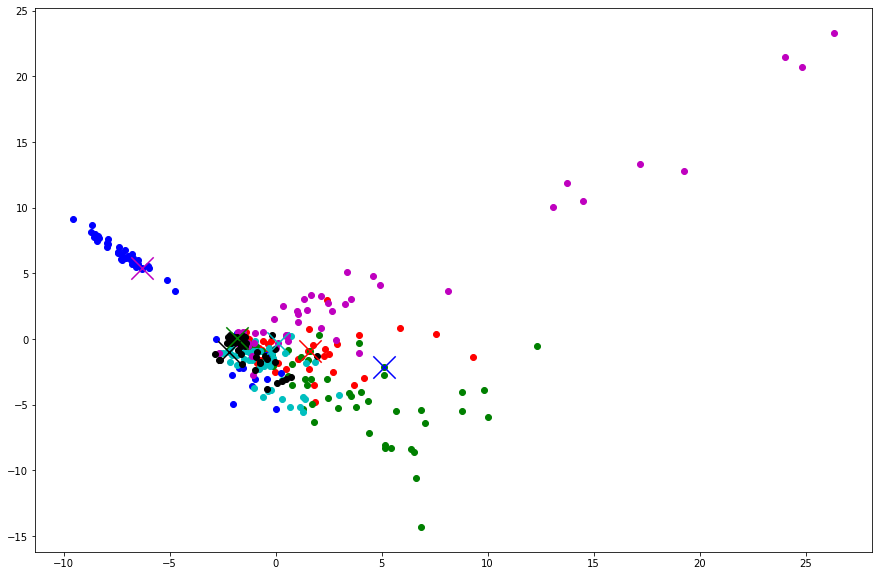

In [ ]:
# Plotting.
fig, ax = plt.subplots( figsize = ( 15, 10 ) )
pca_plot( fig, pca_data, pca_centroids )

In [ ]:
def dist( x, y ):
    return math.sqrt( sum( ( p - q ) ** 2.0 for p, q in zip( x, y ) ) )

# This metric is supposed to work much better than Euclidian distance for text processing.
def cosine_similarity( x, y ):
    return np.dot( x, y ) / ( np.sqrt( np.dot( x, x ) ) * np.sqrt( np.dot( y, y ) ) )

def map_calc_dist( point ):
    return [ dist( point, pca_centroids[i] ) for i in range( k ) ]

def reduce_find_closest( acc, x ):
    return acc + [ np.argmin( x ) ]

def reduce_test( acc, x ):
    return acc + x          # acc and x are numpy arrays.

def map_test( key, value ):
    acc = np.zeros( shape = ( n_pca_dim ) )
    return reduce( reduce_test, value, acc ) / len( value )

parallel_dict = dict()

pool = multiprocessing.Pool( multiprocessing.cpu_count() )

clusters = None

for i in range( 50 ):
    
    # This is parallel.
    cent_dists = list( map( map_calc_dist, pca_data ) )
    clusters = reduce( reduce_find_closest, cent_dists, [] )

    # Preparing data for parallel processing.
    for j in range( k ):
        parallel_dict[j] = list()

    for j in range( N ):
        cluster_number = clusters[j]
        parallel_dict[ cluster_number ].append( pca_data[j] )

    pca_centroids = list( pool.starmap( map_test, parallel_dict.items() ) )

    #print( i )

pool.terminate()

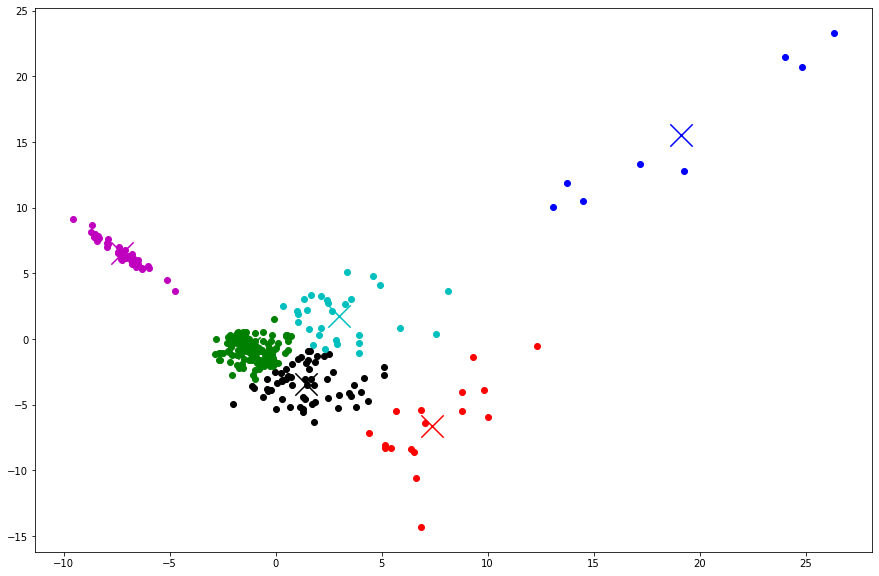

In [ ]:
# Plotting.
fig, ax = plt.subplots( figsize = ( 15, 10 ) )
pca_plot( fig, pca_data, pca_centroids, col_flag = True )

In [ ]:
final_dict = dict()

for i in range( k ):
        final_dict[i] = list()

for i in range( N ):
    final_dict[ clusters[i] ].append( i )

for key, value in final_dict.items():
    print( key, ' -> ', value )